In [16]:
pt = gpd.read_file(r'D:\Projects\FireStations_Build\2022_07\Library\Outputs\finals\FireStation_2022_07.shp')
co = gpd.read_file(r'D:\INTERNAL_DATA\TaxandBoundary_05242022.gdb', driver='FileGDB', layer='County_2022_04')

In [19]:
co = co.loc[co['COUNTY'] == 'Boulder']
pt = pt.clip(co)


In [20]:
co

,FIPSSTCO,STATE,COUNTY,CITY_NAME,CITY_TYPE,ST_PL_FIPS,PL_FIPS,CLASS_CODE,INC_FLAG,DT_ANX,DT_UPD,DT_VRF,CO_GNIS,PARCEL_ALN,Shape_Length,Shape_Area,geometry
199,08013,Colorado,Boulder,,,0800000,00000,H1,0,072009,032015,032015,198122,,2.365106,0.202578,"MULTIPOLYGON (((-105.05769 39.97360, -105.0577..."


In [1]:
import itertools
from operator import itemgetter

import geopandas as gpd
import numpy as np
import pandas as pd

from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString

gpd1 = pt
gpd2 = gpd.GeoDataFrame([['Work', LineString([Point(100, 0), Point(100, 1)])],
                         ['Shops', LineString([Point(101, 0), Point(101, 1), Point(102, 3)])],
                         ['Home',  LineString([Point(101, 0), Point(102, 1)])]],
                        columns=['Place', 'geometry'])


def ckdnearest(gdfA, gdfB, gdfB_cols=['Place']):
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.geometry.to_list()]
    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)
    idx = itemgetter(*idx)(B_ix)
    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

c = ckdnearest(gpd1, gpd2)

<AxesSubplot:>

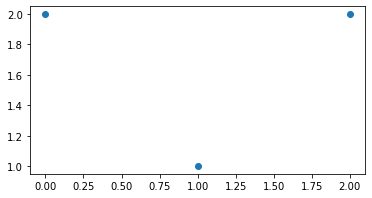

In [5]:
gpd1.plot()

In [12]:
gpd2

,Place,geometry
0,Work,"LINESTRING (100.00000 0.00000, 100.00000 1.00000)"
1,Shops,"LINESTRING (101.00000 0.00000, 101.00000 1.000..."
2,Home,"LINESTRING (101.00000 0.00000, 102.00000 1.00000)"


<AxesSubplot:>

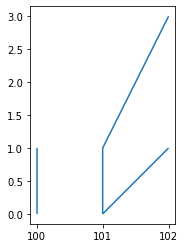

In [11]:
gpd2.plot()

<AxesSubplot:>

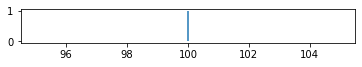

In [15]:
gpd2.loc[gpd2['Place'] == 'Work'].plot()

In [8]:
c

,Name,ID,geometry,Place,dist
0,John,1,POINT (1.00000 1.00000),Work,99.000000
1,Smith,1,POINT (2.00000 2.00000),Work,98.005102
2,Soap,1,POINT (0.00000 2.00000),Work,100.005000
